In [2]:
# Ref: https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/heat.html?highlight=heat%20equation#problem-setup

In [3]:
!pip install deepxde

In [4]:
import deepxde as dde
import numpy as np

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [5]:
def heat_eq_exact_solution(x, t):
    """Returns the exact solution for a given x and t (for sinusoidal initial conditions).

    Parameters
    ----------
    x : np.ndarray
    t : np.ndarray
    """
    return np.exp(-(n**2 * np.pi**2 * a * t) / (L**2)) * np.sin(n * np.pi * x / L)

In [6]:
def gen_exact_solution():
    """Generates exact solution for the heat equation for the given values of x and t."""
    # Number of points in each dimension:
    x_dim, t_dim = (256, 201)

    # Bounds of 'x' and 't':
    x_min, t_min = (0, 0.0)
    x_max, t_max = (L, 1.0)

    # Create tensors:
    t = np.linspace(t_min, t_max, num=t_dim).reshape(t_dim, 1)
    x = np.linspace(x_min, x_max, num=x_dim).reshape(x_dim, 1)
    usol = np.zeros((x_dim, t_dim)).reshape(x_dim, t_dim)

    # Obtain the value of the exact solution for each generated point:
    for i in range(x_dim):
        for j in range(t_dim):
            usol[i][j] = heat_eq_exact_solution(x[i], t[j])

    # Save solution:
    np.savez("heat_eq_data", x=x, t=t, usol=usol)

In [7]:
def gen_testdata():
    x = np.linspace(0, 1, 100)  # 100 spatial points
    t = np.linspace(0, 1, 100)  # 100 time points
    X = np.array([[xi, ti] for xi in x for ti in t])  # Create (x, t) pairs
    y_true = np.sin(np.pi * X[:, 0:1]) * np.exp(-X[:, 1:2])  # Example solution
    return X, y_true

In [8]:
#parameters of the equation
a = 0.4
L = 1
n = 1

In [9]:
#  computational geometry and time domain
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [10]:
# PDE residual of the Heat equation:
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - a * dy_xx

In [11]:
# boundary and initial condition
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime,
    lambda x: np.sin(n * np.pi * x[:, 0:1] / L),
    lambda _, on_initial: on_initial,
)

In [12]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
    num_test=2540,
)

In [13]:
#a fully connected neural network of depth 4 (i.e., 3 hidden layers) and width 20

net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")

In [14]:
# build a Model and choose the optimizer and learning rate
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

Compiling model...
'compile' took 3.598076 s



In [15]:
losshistory, train_state = model.train(iterations=20000)

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.04e-01, 1.03e-01, 4.99e-01]    [2.93e-01, 1.03e-01, 4.99e-01]    []  
1000      [3.39e-03, 1.66e-03, 1.64e-03]    [2.29e-03, 1.66e-03, 1.64e-03]    []  
2000      [6.35e-04, 1.22e-04, 4.96e-05]    [4.24e-04, 1.22e-04, 4.96e-05]    []  
3000      [1.47e-04, 5.48e-06, 6.40e-06]    [1.08e-04, 5.48e-06, 6.40e-06]    []  
4000      [8.77e-05, 1.07e-06, 4.61e-06]    [6.71e-05, 1.07e-06, 4.61e-06]    []  
5000      [6.84e-05, 3.02e-06, 3.70e-06]    [5.37e-05, 3.02e-06, 3.70e-06]    []  
6000      [5.46e-05, 9.59e-07, 2.02e-06]    [4.32e-05, 9.59e-07, 2.02e-06]    []  
7000      [4.58e-05, 9.36e-07, 1.31e-06]    [3.61e-05, 9.36e-07, 1.31e-06]    []  
8000      [3.77e-05, 8.90e-07, 8.78e-07]    [3.02e-05, 8.90e-07, 8.78e-07]    []  
9000      [5.38e-05, 3.38e-06, 1.60e-05]    [3.93e-05, 3.38e-06, 1.60e-05]    []  
10000     [2.72e-05, 7.96e-07, 3.61e-07]    [2.18e-05, 7.96e-

In [16]:
#After we train the network using Adam, we continue to train the network using L-BFGS to achieve a smaller loss

model.compile("L-BFGS-B")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.001377 s

Training model...

Step      Train loss                        Test loss                         Test metric
20000     [1.04e-05, 8.23e-07, 2.39e-06]    [8.35e-06, 8.23e-07, 2.39e-06]    []  

Best model at step 18000:
  train loss: 1.08e-05
  test loss: 9.34e-06
  test metric: []

'train' took 0.032597 s



Saving loss history to C:\Users\Akanksha\Documents\loss.dat ...
Saving training data to C:\Users\Akanksha\Documents\train.dat ...
Saving test data to C:\Users\Akanksha\Documents\test.dat ...


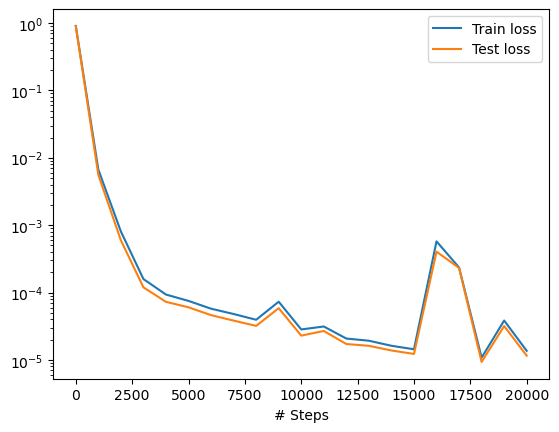

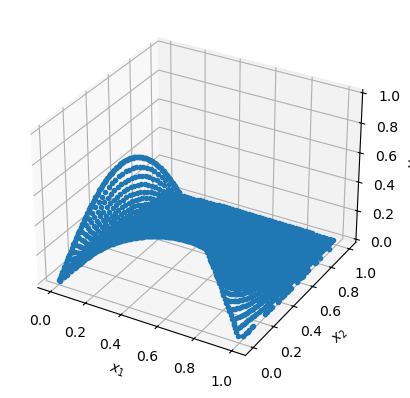

Mean residual: 0.0022429526
L2 relative error: 0.6016666089852498


In [17]:
#results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)
X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

In [18]:
############# numerical method

In [19]:
'''
initial condition : u(x,0) = sin(npix/L)
boundary condition : u(0,t) = u(1,t) = 0
'''

'\ninitial condition : u(x,0) = sin(npix/L)\nboundary condition : u(0,t) = u(1,t) = 0\n'

In [20]:
#FTCS
import numpy as np
import matplotlib.pyplot as plt

# Physical parameters
a = 0.4
L = 1
n = 1

# Discretization
Nx = 50         # number of spatial steps
Nt = 10000        # number of time steps
dx = L / (Nx - 1)
dt = 1.0 / Nt
x = np.linspace(0, L, Nx)
t = np.linspace(0, 1, Nt + 1)

# Stability condition: r = a*dt/dx^2 < 0.5
r = a * dt / dx**2
assert r < 0.5, f"Stability condition failed: r = {r} >= 0.5"

In [21]:
# Initial condition: u(x,0) = sin(nπx/L)
u = np.zeros((Nt + 1, Nx))
u[0, :] = np.sin(n * np.pi * x / L)

# Boundary conditions: u(0,t) = u(L,t) = 0
u[:, 0] = 0
u[:, -1] = 0


In [22]:
for j in range(0, Nt):
    for i in range(1, Nx - 1):
        u[j + 1, i] = u[j, i] + r * (u[j, i - 1] - 2 * u[j, i] + u[j, i + 1])


L2 error (Numerical vs PINN): 0.0032199403868866387


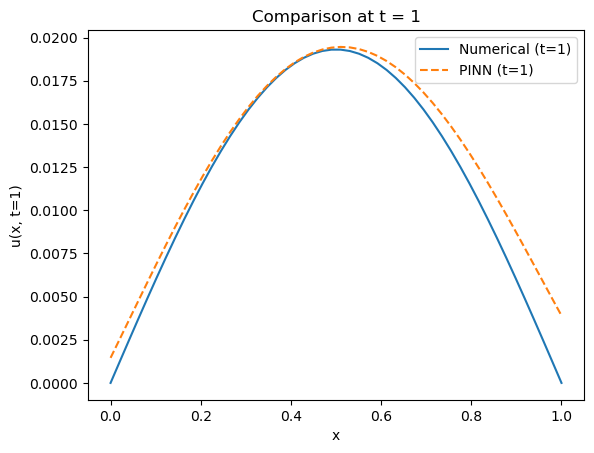

In [49]:
# Prepare test data as in gen_testdata()
X = np.array([[xi, ti] for ti in t for xi in x])
y_pinn = model.predict(X)                                # PINN solution

# Flatten the numerical solution to match (x, t) order in X
u_numeric = u.flatten().reshape(-1, 1)

# Compute errors
from deepxde.metrics import l2_relative_error
print("L2 error (Numerical vs PINN):", l2_relative_error(y_pinn, u_numeric))

# Optional: plot comparison at final time
plt.plot(x, u[-1], label="Numerical (t=1)")
plt.plot(x, y_pinn[-Nx:], '--', label="PINN (t=1)")
plt.xlabel("x")
plt.ylabel("u(x, t=1)")
plt.legend()
plt.title("Comparison at t = 1")
plt.show()